## Turkish Instructions Retrieval Emsemble

### Import Libraries

In [1]:
import sys
import os
import pickle

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

#### Set Path and Constant Values

In [2]:
# Set Constants

# If use Google Colab
use_colab = False
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    # ROOT_PATH = r"G:\Drive'ım\Colab Notebooks\HW3"
    ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/HW3"
else:
    ROOT_PATH = os.getcwd()

CACHE_PATH = os.path.join(ROOT_PATH, 'cache')
DATA_PATH = os.path.join(ROOT_PATH, 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
EMBEDDING_DATA_PATH = os.path.join(DATA_PATH, 'embedding')

# Create Folders
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(EMBEDDING_DATA_PATH, exist_ok=True)
os.makedirs(CACHE_PATH, exist_ok=True)

### Embedding Models

In [3]:
model_name_mapping = {
    "sentence-transformers__all-MiniLM-L12-v2": "MiniLM",
    "jinaai__jina-embeddings-v3": "Jina",
    "intfloat__multilingual-e5-large-instruct": "E5-Large",
    "BAAI__bge-m3": "BGE-M3",
    "ytu-ce-cosmos__turkish-colbert": "ColBERT",
    # "thenlper__gte-large": "GTE Large"
}

# Embedding modellerin dosya isimleri
model_files = list(model_name_mapping.keys())

#### Load Embedding Files

In [4]:
# Fonksiyon: Embedding Dosyalarını Yükle
def load_embeddings(model_name):
    # Soru ve cevaplar için farklı dosyalara embedding'leri kaydetmiştik
    ds_name = "databricks-dolly-15k-tr"
    question_file = os.path.join(EMBEDDING_DATA_PATH, ds_name, f"question_{model_name}_embeddings.csv.gz")
    answer_file = os.path.join(EMBEDDING_DATA_PATH, ds_name, f"answer_{model_name}_embeddings.csv.gz")
    df_questions = pd.read_csv(question_file, compression='gzip')
    df_answers = pd.read_csv(answer_file, compression='gzip')

    # İlk sütunlar (soru ve cevap) metin olduğu için çıkartılıyor.
    return df_questions.iloc[:, 1:].values, df_answers.iloc[:, 1:].values

### Cosine Similarity

#### Description

![Alt text](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg "a title")

#### Calculate Cosine Similarity and Save Pickle

In [5]:
def compute_cosine_similarity():
    ds_name = "databricks-dolly-15k-tr"
    file_path = os.path.join(CACHE_PATH, ds_name+"cosine_similarity_data.pkl")
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            print("Daha önce kaydedilmiş cosine similarity verileri yüklendi.")
            return pickle.load(f)
    else:
        print("Cosine similarity hesaplanıyor...")
        similarity_data = {model: cosine_similarity(*load_embeddings(model)) for model in model_files}
        with open(file_path, "wb") as f:
            pickle.dump(similarity_data, f)
        print("Cosine similarity hesaplandı ve pickle dosyasına kaydedildi.")
        return similarity_data

#### Load Sampled Dataset

In [7]:
ds_name = "databricks-dolly-15k-tr"
df_sample = pd.read_csv(os.path.join(RAW_DATA_PATH, ds_name, "sampled_turkish_instructions.csv"))

#### Select a sample index for question. Explain to calculate top-1 and top-5 performance

In [8]:
# Örnek bir soru için indeks seçimi
example_question_index = 0
example_question_text = df_sample.iloc[example_question_index]['soru']
example_correct_answer = df_sample.iloc[example_question_index]['cevap']

# Her model için cevap adaylarını gösterimi
print(f"Örnek Soru: {example_question_text}")
print(f"Gerçek Cevap: {example_correct_answer}\n")
print("-" * 80)

for model_name in model_files:
    print(f"Model: {model_name}\n")

    # Embedding'leri yükleme
    question_embeddings, answer_embeddings = load_embeddings(model_name)

    # Örnek sorunun embedding'i
    question_embedding = question_embeddings[example_question_index].reshape(1, -1)

    # Tüm cevap embedding'leri ile cosine similarity hesaplama
    similarity_scores = cosine_similarity(question_embedding, answer_embeddings).flatten()

    sorted_indices = np.argsort(similarity_scores)[::-1]
    top5_indices = sorted_indices[:5]

    print("Top-5 Cevap Adayları:")
    for rank, idx in enumerate(top5_indices, 1):
        candidate_answer = df_sample.iloc[idx]['cevap']
        similarity_score = similarity_scores[idx]
        print(f"  {rank}. [{similarity_score:.4f}] {candidate_answer}")

    top1_index = sorted_indices[0]
    top1_candidate = df_sample.iloc[top1_index]['cevap']
    print(f"\nTop-1 Cevap: [{similarity_scores[top1_index]:.4f}] {top1_candidate}\n")
    print("-" * 40)

Örnek Soru: Kara ceviz ağaçları nerede yetişir? Doğu Amerika kara cevizi olan Juglans nigra, Kuzey Amerika'ya özgü Juglandaceae ceviz ailesindeki yaprak döken bir ağaç türüdür. Çoğunlukla güney Ontario'dan, batıdan güneydoğuya Güney Dakota'ya, güneyden Georgia'ya, kuzey Florida'ya ve güneybatıdan Teksas'ın merkezine kadar nehir kıyısındaki bölgelerde yetişir. Yukarı Ottawa Vadisi'ndeki yabani ağaçlar, izole edilmiş bir yerli popülasyon olabilir veya dikilmiş ağaçlardan türemiş olabilir.
Gerçek Cevap: Güney Ontario'dan Kuzey Amerika, batıdan güneydoğuya Güney Dakota, güneyden Georgia'ya, kuzey Florida'dan ve güneybatıdan Teksas'ın merkezine.

--------------------------------------------------------------------------------
Model: sentence-transformers__all-MiniLM-L12-v2

Top-5 Cevap Adayları:
  1. [0.6950] Karadeniz, Avrupa ile Asya arasında, Balkanların doğusunda, Doğu Avrupa Ovası'nın güneyinde, Kafkasya'nın batısında ve Anadolu'nun kuzeyinde yer alır. Bulgaristan, Gürcistan, Romanya, 

#### Calculate all cosine similarity for all embedding models

In [9]:
# Tüm embeddingler için cosine similarity hesapla
cosine_similarity_data = compute_cosine_similarity()

Cosine similarity hesaplanıyor...
Cosine similarity hesaplandı ve pickle dosyasına kaydedildi.


### Result & Conclusion

#### All Embedding Model: Accuracy and Error

In [10]:
# Her modelin Top-1 ve Top-5 performanslarını saklamak için
model_results = {}

print(f"{'Model Name':<45} {'Top-1 Accuracy':<15} {'Top-5 Accuracy':<15} {'Top-1 Errors':<20} {'Top-5 Errors':<20}")
print("-" * 120)

for model_name in model_files:
    # Embedding'leri yükleme
    question_embeddings, answer_embeddings = load_embeddings(model_name)

    # Daha önce hesaplanan cosine similarity matrisini yükle
    similarity_matrix = cosine_similarity_data[model_name]

    # Top-1, Top-5 doğruluk ve hata hesaplama
    top1_correct, top5_correct = 0, 0
    top1_errors, top5_errors = 0, 0
    total_questions = len(similarity_matrix)

    for idx, row in enumerate(similarity_matrix):
        sorted_indices = np.argsort(row)[::-1]  # Büyükten küçüğe sıralama
        correct_answer_idx = idx  # Her sorunun doğru cevabı aynı indeksde yer alıyor

        # Top-1 doğruluk kontrolü (cevap ilk sırada mı?)
        if correct_answer_idx == sorted_indices[0]:
            top1_correct += 1
        else:
            top1_errors += 1  # Top-1 hatası

        # Top-5 doğruluk kontrolü (cevap ilk 5'te mi?)
        if correct_answer_idx in sorted_indices[:5]:
            top5_correct += 1
        else:
            top5_errors += 1  # Top-5 hatası

    top1_accuracy = top1_correct / total_questions
    top5_accuracy = top5_correct / total_questions

    top1_error_percentage = (top1_errors / total_questions) * 100
    top5_error_percentage = (top5_errors / total_questions) * 100

    model_results[model_name] = {
        "Top-1 Accuracy": top1_accuracy,
        "Top-5 Accuracy": top5_accuracy,
        "Top-1 Errors": top1_errors,
        "Top-5 Errors": top5_errors,
        "Top-1 Error %": top1_error_percentage,
        "Top-5 Error %": top5_error_percentage
    }
    # print(f"{model_name} - Top-1 Accuracy: {top1_accuracy:.4f}, Top-5 Accuracy: {top5_accuracy:.4f}")
    print(f"{model_name:<45} {top1_accuracy:<15.4f} {top5_accuracy:<15.4f} "
          f"{top1_errors:<6} ({top1_error_percentage:>4.2f}%)     {top5_errors:<6} ({top5_error_percentage:>4.2f}%)")

Model Name                                    Top-1 Accuracy  Top-5 Accuracy  Top-1 Errors         Top-5 Errors        
------------------------------------------------------------------------------------------------------------------------
sentence-transformers__all-MiniLM-L12-v2      0.4850          0.6015          1030   (51.50%)     797    (39.85%)
jinaai__jina-embeddings-v3                    0.8665          0.9485          267    (13.35%)     103    (5.15%)
intfloat__multilingual-e5-large-instruct      0.7530          0.8805          494    (24.70%)     239    (11.95%)
BAAI__bge-m3                                  0.8020          0.8835          396    (19.80%)     233    (11.65%)
ytu-ce-cosmos__turkish-colbert                0.4150          0.5595          1170   (58.50%)     881    (44.05%)


#### Graph: Compare All Embedding Model's Accuracy

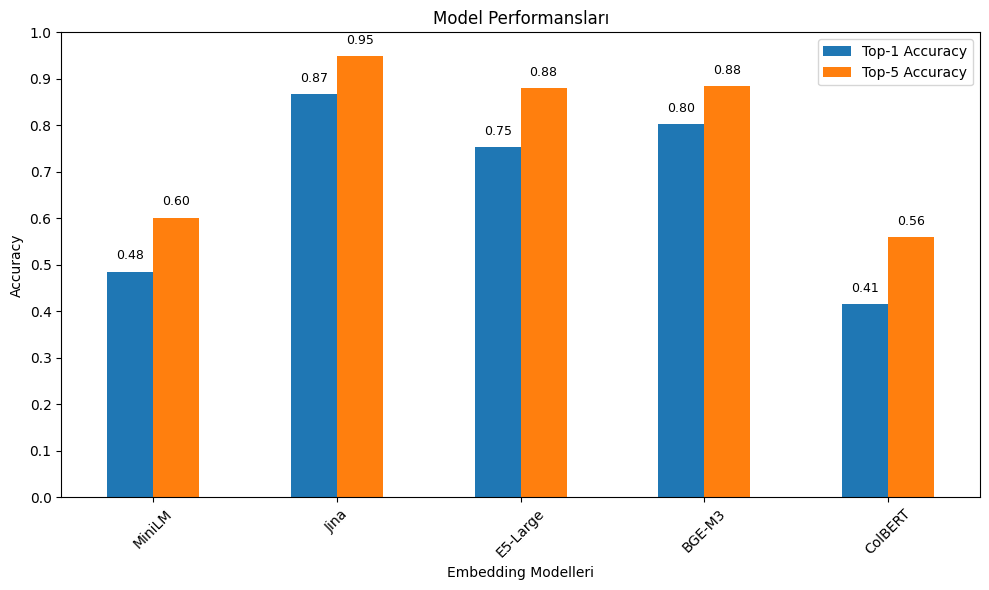

In [11]:
results_df = pd.DataFrame(model_results).T  # Transpose yaparak modelleri satır haline getir
results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "Model"}, inplace=True)

# Model isimlerini kısaltmak için
results_df['Embedding Modelleri'] = results_df['Model'].map(model_name_mapping)

ax = results_df.plot(
    x="Embedding Modelleri",
    y=["Top-1 Accuracy", "Top-5 Accuracy"],
    kind="bar",
    figsize=(10, 6),
    legend=True
)

plt.title("Model Performansları")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.yticks(np.arange(0.0, 1.1, 0.1))

# Barların üzerinde değerleri ekleme
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()

#### All Ensemble Methods Accuracy

### 1. Majority Voting

Her bir örnek soru için tekil modelin Top-1 ve Top-5 cevap adayı listelerine bakılır, her bir listedeki aday diğer modellerin de listelerinde yer alıyorsa oyu 1 artırılır. En yüksek oya sahip cevap adayı ensemble sonucu olarak belirlenir.

$$
\begin{equation}
\tag{1}
\quad \hat{y}_= \text{argmax}_i \Big( \sum_{j=1}^M \mathbb{1}[i \in \text{Top-X}_j] \Big) \\
\end{equation}
$$

$ \mathbb{1}[i \in \text{Top-5}_j] $ : i'inci cevabın j'inci modelin Top-X tahmininde olup olmadığını kontrol eden gösterge fonksiyonu ifade eder. 1 ise var, 0 ise yoktur.

---

### 2. Average Cosine Similarity

Her bir tekil modelin her bir cevaba ilişkin hesapladığı cosinüs benzerliklerinin ortalaması alınır. En yüksek ortalamaya ait ilk cevap Top-1, ilk 5 cevap ise Top-5 ensemble sonucu olarak belirlenir. 

$$
\begin{equation}
\tag{2}
\quad \hat{y} = \text{argmax}_i \Big( \frac{1}{M} \sum_{j=1}^M S_{ij} \Big) \\
\end{equation}
$$

$ S_{ij} $ : "j-inci model tarafından i-inci cevap için hesaplanan cosine similarity skorudur.

---

### 3. Weighted Cosine Similarity

Her bir tekil modelin Top-1 doğruluk oranları normalize edilerek toplam 5 farklı modele ait elde edilen değerler toplamı 1 olacak şekilde $ w{_j} $ olarak ağırlıklandırılmıştır. Model kararlarını birleştirirken tekil başarısı daha yüksek olan modelin ağırlığı daha yüksek olduğu için karara olan etkisi daha fazla olacaktır.

Tüm modellerin cosinüs benzerlikleri kendi ağırlıkları ile çarpıldığında en yüksek skora sahip ilk cevap Top-1, ilk 5 cevap ise Top-5 ensemble sonucu olarak belirlenir. 

$$
\begin{equation}
\tag{3}
\quad \hat{y} = \text{argmax}_i \Big( \sum_{j=1}^M w_j \cdot S_{ij} \Big) \\
\end{equation}
$$

$ w{_j} $ : j-inci modelin ağırlığını ifade etmektedir. (j-inci modelin tekil Top-1 doğruluğunun normalize edilmiş hali)

$ S_{ij} $ : j-inci model tarafından i-inci cevap için hesaplanan cosine similarity skorudur.

In [12]:
from collections import Counter

# Ensemble sonuçlarını saklamak için
ensemble_results = {
    "Majority Voting": {"Top-1": 0, "Top-5": 0},
    "Average Cosine": {"Top-1": 0, "Top-5": 0},
    "Weighted Average": {"Top-1": 0, "Top-5": 0}
}

# Model ağırlıklarını tekil performanslardan (Top-1 Accuracy) hesaplama: 3.ensemble yöntemi için
top1_accuracies = {model: result["Top-1 Accuracy"] for model, result in model_results.items()}
# Ağırlıkları normalleştiriyoruz (Toplam ağırlık = 1 olacak şekilde)
total_accuracy = sum(top1_accuracies.values())
model_weights = {model: accuracy / total_accuracy for model, accuracy in top1_accuracies.items()}

# Ensemble hesaplama
for idx in range(len(df_sample)):
    # Her modelin benzerlik skorlarını ve sıralamalarını sakla
    all_similarities = []
    all_top5_candidates = []

    for model_name, similarity_matrix in cosine_similarity_data.items():
        row = similarity_matrix[idx]  # İlgili sorunun tüm cevaplarla benzerlik skorları
        sorted_indices = np.argsort(row)[::-1]

        # Top-5 adayları ve skorları
        all_top5_candidates.append(sorted_indices[:5])
        all_similarities.append(row)

    # Gerçek cevap indeksi
    correct_answer_idx = idx

    # Ensemble 1: Majority Voting

    flattened_top5 = [idx for sublist in all_top5_candidates for idx in sublist]
    most_common = Counter(flattened_top5).most_common(1)[0][0]  # En sık geçen cevap
    if most_common == correct_answer_idx:
        ensemble_results["Majority Voting"]["Top-1"] += 1
    if correct_answer_idx in Counter(flattened_top5).keys():
        ensemble_results["Majority Voting"]["Top-5"] += 1

    # Ensemble 2: Average Cosine Similarity
    avg_scores = np.mean(all_similarities, axis=0)
    avg_sorted_indices = np.argsort(avg_scores)[::-1]
    if avg_sorted_indices[0] == correct_answer_idx:
        ensemble_results["Average Cosine"]["Top-1"] += 1
    if correct_answer_idx in avg_sorted_indices[:5]:
        ensemble_results["Average Cosine"]["Top-5"] += 1

    # Ensemble 3: Weighted Cosine Similarity
    weighted_scores = sum(
        model_weights[model_files[i]] * all_similarities[i] for i in range(len(model_files))
    )
    weighted_sorted_indices = np.argsort(weighted_scores)[::-1]
    if weighted_sorted_indices[0] == correct_answer_idx:
        ensemble_results["Weighted Average"]["Top-1"] += 1
    if correct_answer_idx in weighted_sorted_indices[:5]:
        ensemble_results["Weighted Average"]["Top-5"] += 1

# Ensemble doğruluk oranlarını hesapla
for method, results in ensemble_results.items():
    results["Top-1 Accuracy"] = results["Top-1"] / len(df_sample)
    results["Top-5 Accuracy"] = results["Top-5"] / len(df_sample)

print("Ensemble Performans Sonuçları\n")
print(f"{'Ensemble Method Name':<30} {'Top-1 Accuracy':<15} {'Top-5 Accuracy':<15}")
print("-" * 60)
for method, results in ensemble_results.items():
    print(f"{method:<30} {results['Top-1 Accuracy']:<15.4f} {results['Top-5 Accuracy']:<15.4f}")

Ensemble Performans Sonuçları

Ensemble Method Name           Top-1 Accuracy  Top-5 Accuracy 
------------------------------------------------------------
Majority Voting                0.7665          0.9580         
Average Cosine                 0.8080          0.8915         
Weighted Average               0.8240          0.9095         


#### Select a sample index for question. Explain to calculate top-1 and top-5 performance with 3 different ensemble methods

In [13]:
# Örnek soru indeksi
example_question_index = 0  # İlk soru (istediğiniz indeksi burada değiştirebilirsiniz)

# Gerçek soruyu ve cevabı kontrol et
example_question = df_sample.iloc[example_question_index]['soru']
correct_answer = df_sample.iloc[example_question_index]['cevap']

print(f"Örnek Soru: {example_question}")
print(f"Gerçek Cevap: {correct_answer}\n")

# Her modelin Top-5 adaylarını ve cosine similarity skorlarını sakla
all_similarities = []
all_top5_candidates = []

for model_name in model_files:
  similarity_matrix = cosine_similarity_data[model_name]
  row = similarity_matrix[example_question_index]  # Örnek sorunun tüm cevaplarla benzerlik skorları
  sorted_indices = np.argsort(row)[::-1]  # Skorları büyükten küçüğe sırala

  # Top-5 adayları ve skorları
  all_top5_candidates.append(sorted_indices[:5])
  all_similarities.append(row)

# Ensemble 1: Majority Voting (Top-1 ve Top-5)
flattened_top5 = [idx for sublist in all_top5_candidates for idx in sublist]
most_common = Counter(flattened_top5).most_common(1)[0][0]  # En sık geçen cevap
ensemble_majority_voting = df_sample.iloc[most_common]['cevap']
majority_top5 = [item[0] for item in Counter(flattened_top5).most_common(5)]

# Ensemble 2: Average Cosine Similarity (Top-1 ve Top-5)
avg_scores = np.mean(all_similarities, axis=0)
avg_sorted_indices = np.argsort(avg_scores)[::-1]
ensemble_avg_cosine = df_sample.iloc[avg_sorted_indices[0]]['cevap']
average_top5 = avg_sorted_indices[:5]

# Ensemble 3: Weighted Average (Top-1 ve Top-5)
weighted_scores = sum(
    model_weights[model_name] * all_similarities[i] for i, model_name in enumerate(model_files)
)
weighted_sorted_indices = np.argsort(weighted_scores)[::-1]
ensemble_weighted_avg = df_sample.iloc[weighted_sorted_indices[0]]['cevap']
weighted_top5 = weighted_sorted_indices[:5]

# Sonuçları yazdır
print("Ensemble Yöntemlerinin Top-1 Cevapları:")
print("\nMajority Voting Cevabı:")
print(f"  [Frekans: {Counter(flattened_top5)[most_common]}] {ensemble_majority_voting}")

print("\nAverage Cosine Similarity Cevabı:")
print(f"  [Benzerlik (Avg): {avg_scores[avg_sorted_indices[0]]:.4f}] {ensemble_avg_cosine}")

print("\nWeighted Average Cevabı:")
print(f"  [Benzerlik (Weighted): {weighted_scores[weighted_sorted_indices[0]]:.4f}] {ensemble_weighted_avg}\n")

print("Ensemble Yöntemlerinin Top-5 Cevapları ve Skorları:")

# Majority Voting
print("\nMajority Voting Top-5 Cevaplar:")
for rank, idx in enumerate(majority_top5, 1):
    print(f"  {rank}. [Frekans: {Counter(flattened_top5)[idx]}] {df_sample.iloc[idx]['cevap']}")

# Average Cosine Similarity
print("\nAverage Cosine Top-5 Cevaplar:")
for rank, idx in enumerate(average_top5, 1):
    print(f"  {rank}. [Benzerlik (Avg): {avg_scores[idx]:.4f}] {df_sample.iloc[idx]['cevap']}")

# Weighted Average
print("\nWeighted Average Top-5 Cevaplar:")
for rank, idx in enumerate(weighted_top5, 1):
    print(f"  {rank}. [Benzerlik (Weighted): {weighted_scores[idx]:.4f}] {df_sample.iloc[idx]['cevap']}")

Örnek Soru: Kara ceviz ağaçları nerede yetişir? Doğu Amerika kara cevizi olan Juglans nigra, Kuzey Amerika'ya özgü Juglandaceae ceviz ailesindeki yaprak döken bir ağaç türüdür. Çoğunlukla güney Ontario'dan, batıdan güneydoğuya Güney Dakota'ya, güneyden Georgia'ya, kuzey Florida'ya ve güneybatıdan Teksas'ın merkezine kadar nehir kıyısındaki bölgelerde yetişir. Yukarı Ottawa Vadisi'ndeki yabani ağaçlar, izole edilmiş bir yerli popülasyon olabilir veya dikilmiş ağaçlardan türemiş olabilir.
Gerçek Cevap: Güney Ontario'dan Kuzey Amerika, batıdan güneydoğuya Güney Dakota, güneyden Georgia'ya, kuzey Florida'dan ve güneybatıdan Teksas'ın merkezine.

Ensemble Yöntemlerinin Top-1 Cevapları:

Majority Voting Cevabı:
  [Frekans: 4] Yerli alabalık doğu Kuzey Amerika'da, kuzeydoğu Kanada'dan ve doğu kıyısının aşağısında, birçok yüksek rakımlı akarsuda bulundukları Amerika Birleşik Devletleri'ndeki Georgia eyaletine kadar güneyde bulunabilir. Bu bölgelere özgü olmasına rağmen, dere alabalığı, popülas

#### Graph: Compare All Embedding Models vs. Ensemble Models Accuracy

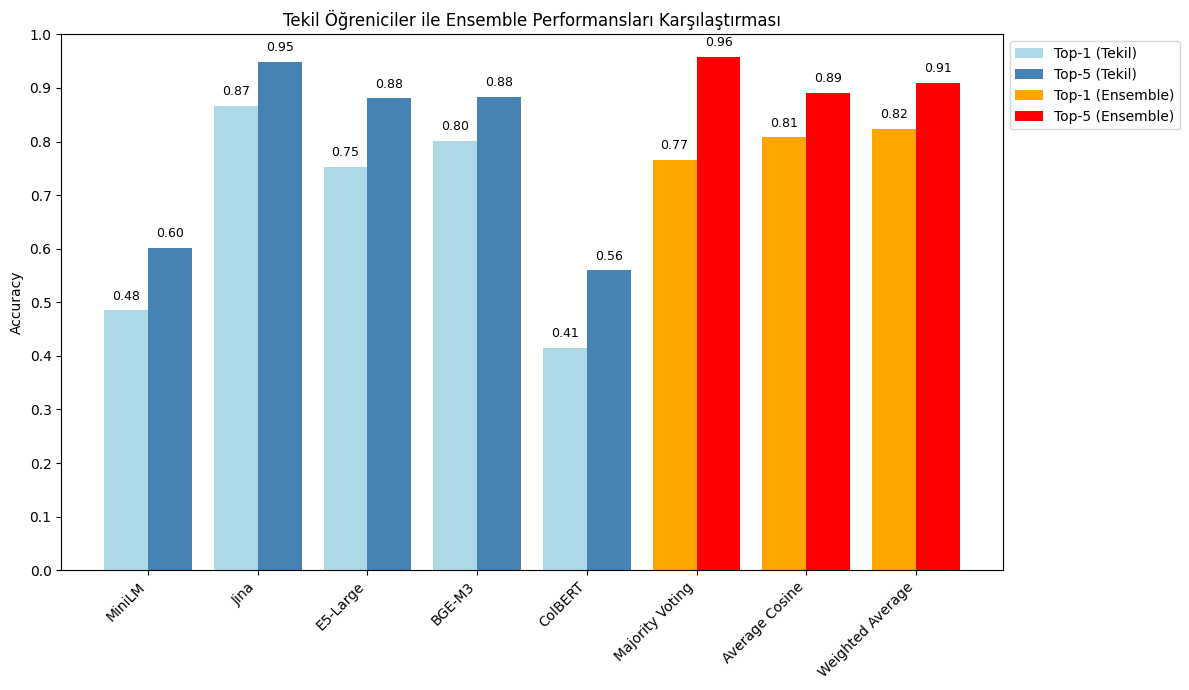

In [14]:
from matplotlib.patches import Patch

# Tekil modellerin başarıları
model_names = [model_name_mapping[model] for model in model_files]
top1_accuracies = [model_results[model]["Top-1 Accuracy"] for model in model_files]
top5_accuracies = [model_results[model]["Top-5 Accuracy"] for model in model_files]

# Ensemble yöntemlerinin başarıları
ensemble_methods = list(ensemble_results.keys())
ensemble_top1 = [ensemble_results[method]["Top-1 Accuracy"] for method in ensemble_methods]
ensemble_top5 = [ensemble_results[method]["Top-5 Accuracy"] for method in ensemble_methods]

# Verileri birleştirme işlemi
x_labels = model_names + ensemble_methods
top1_combined = top1_accuracies + ensemble_top1
top5_combined = top5_accuracies + ensemble_top5

x = np.arange(len(x_labels))

bar_width = 0.4

colors_top1 = ['lightblue'] * len(model_names) + ['orange'] * len(ensemble_methods)
colors_top5 = ['steelblue'] * len(model_names) + ['red'] * len(ensemble_methods)

plt.figure(figsize=(12, 7))

bars1 = plt.bar(x - bar_width / 2, top1_combined, bar_width, label="Top-1 Accuracy", color=colors_top1)

bars2 = plt.bar(x + bar_width / 2, top5_combined, bar_width, label="Top-5 Accuracy", color=colors_top5)

# Barların üzerinde değerlerin gösterimi
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{bar.get_height():.2f}", ha='center', fontsize=9)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{bar.get_height():.2f}", ha='center', fontsize=9)

plt.xticks(x, x_labels, rotation=45, ha="right")
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.title("Tekil Öğreniciler ile Ensemble Performansları Karşılaştırması")
plt.ylim(0, 1)

legend_elements = [
    Patch(facecolor='lightblue', label="Top-1 (Tekil)"),
    Patch(facecolor='steelblue', label="Top-5 (Tekil)"),
    Patch(facecolor='orange', label="Top-1 (Ensemble)"),
    Patch(facecolor='red', label="Top-5 (Ensemble)")
]

# Legend'i ekle
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()